In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GRU, Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
import os
import glob

In [2]:
WINDOW_SIZE = 30  
RANDOM_STATE = 42
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 0.001

In [3]:
def load_and_preprocess_data(file_paths, window_size=WINDOW_SIZE):
    """
    טעינה ועיבוד מקדים של הנתונים מקבצי האקסל
    """
    all_data = []
    
    for file_path in file_paths:
        df = pd.read_csv(file_path) if file_path.endswith('.csv') else pd.read_excel(file_path)
        
        # בדיקה שקיימים העמודות הנדרשות
        required_columns = ['video_id', 'frame', 'window_id', 
                           'overall_movement_score', 'dominant_knee', 'dominant_elbow']
        
        if not all(col in df.columns for col in required_columns):
            print(f"קובץ {file_path} חסרות עמודות נדרשות. דילוג...")
            continue
        
        df = df[~df['video_id'].isin([43, 44])]
        all_data.append(df)
    
    if not all_data:
        raise ValueError("לא נמצאו קבצים תקינים לעיבוד")
    
    # איחוד כל הנתונים
    data = pd.concat(all_data, ignore_index=True)
    
    # המרת ערכים קטגוריאליים למספרים
    label_encoders = {}
    for col in ['dominant_knee', 'dominant_elbow']:
        if data[col].dtype == 'object':
            le = LabelEncoder()
            data[col] = le.fit_transform(data[col])
            label_encoders[col] = le
    
    return data, label_encoders

def prepare_sequences(data, window_size=WINDOW_SIZE):
    """
    הכנת רצפי נתונים עבור GRU לפי חלונות
    """
    feature_columns = [col for col in data.columns if any(x in col for x in 
                      ['_x', '_y', '_confidence'])]
    
    X = []
    y_movement = []
    y_knee = []
    y_elbow = []
    
    # קיבוץ לפי וידאו וחלון
    groups = data.groupby(['video_id', 'window_id'])
    
    for (vid_id, win_id), group in groups:
        if len(group) < window_size:
            # דילוג על חלונות קטנים מדי
            continue
        
        # לכל חלון, ניקח רצפים באורך window_size
        for i in range(0, len(group) - window_size + 1):
            sequence = group.iloc[i:i+window_size][feature_columns].values
            
            # המטרות הן הערכים בפריים האחרון ברצף
            target_frame = group.iloc[i+window_size-1]
            
            X.append(sequence)
            y_movement.append(target_frame['overall_movement_score'])
            y_knee.append(target_frame['dominant_knee'])
            y_elbow.append(target_frame['dominant_elbow'])
    
    X = np.array(X)
    y_movement = np.array(y_movement)
    y_knee = np.array(y_knee)
    y_elbow = np.array(y_elbow)
    
    return X, y_movement, y_knee, y_elbow, feature_columns

def build_gru_model(input_shape, num_knee_classes, num_elbow_classes):
    """
    בניית מודל GRU עם מספר שכבות והתאמה למשימות מרובות
    """
    # שכבת הקלט המשותפת
    inputs = Input(shape=input_shape)
    
    # שכבות GRU משותפות
    x = GRU(128, return_sequences=True)(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    x = GRU(64)(x)
    x = BatchNormalization()(x)
    shared_features = Dropout(0.3)(x)
    
    # ענף לציון תנועה כללי (רגרסיה)
    movement_output = Dense(32, activation='relu')(shared_features)
    movement_output = Dense(1, name='movement_score')(movement_output)
    
    # ענף לברך דומיננטית (סיווג)
    knee_output = Dense(32, activation='relu')(shared_features)
    knee_output = Dense(num_knee_classes, activation='softmax', name='dominant_knee')(knee_output)
    
    # ענף למרפק דומיננטי (סיווג)
    elbow_output = Dense(32, activation='relu')(shared_features)
    elbow_output = Dense(num_elbow_classes, activation='softmax', name='dominant_elbow')(elbow_output)
    
    # הגדרת המודל עם קלט ושלושה פלטים
    model = Model(inputs=inputs, outputs=[movement_output, knee_output, elbow_output])
    
    # הגדרת אופטימייזר ופונקציות שגיאה
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss={
            'movement_score': 'mean_squared_error',
            'dominant_knee': 'sparse_categorical_crossentropy',
            'dominant_elbow': 'sparse_categorical_crossentropy'
        },
        metrics={
            'movement_score': ['mae'],
            'dominant_knee': ['accuracy'],
            'dominant_elbow': ['accuracy']
        }
    )
    
    return model

def train_model(X_train, y_train, X_val, y_val, input_shape, num_knee_classes, num_elbow_classes):
    
    model = build_gru_model(input_shape, num_knee_classes, num_elbow_classes)
    
    # הגדרת callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss', 
        patience=15, 
        restore_best_weights=True
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=0.00001
    )
    
    model_checkpoint = ModelCheckpoint(
        'best_infant_movement_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
    
    # אימון המודל
    history = model.fit(
        X_train,
        y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, reduce_lr, model_checkpoint],
        verbose=1
    )
    
    return model, history

def evaluate_model(model, X_test, y_test_movement, y_test_knee, y_test_elbow, label_encoders):
    """
    הערכת המודל והצגת מדדי ביצוע
    """
    # ביצוע חיזוי
    y_pred_movement, y_pred_knee_prob, y_pred_elbow_prob = model.predict(X_test)
    
    # המרת הסתברויות לתוויות
    y_pred_knee = np.argmax(y_pred_knee_prob, axis=1)
    y_pred_elbow = np.argmax(y_pred_elbow_prob, axis=1)
    
    # מדדי ביצוע לציון תנועה כללי
    mse_movement = mean_squared_error(y_test_movement, y_pred_movement)
    rmse_movement = np.sqrt(mse_movement) # ציון בין 0-10 שמודד עד כמה המודל שגה בחישוב ציון התנועה הכללי- כמה רחוק המודל היהי מהציון תנועה הכללי האמיתי שחושב
    
    # מדדי ביצוע לסיווג ברך ומרפק דומיננטיים
    knee_accuracy = accuracy_score(y_test_knee, y_pred_knee)
    elbow_accuracy = accuracy_score(y_test_elbow, y_pred_elbow)
    
    print("\n===== תוצאות המודל =====")
    print(f"RMSE לציון תנועה כללי: {rmse_movement:.4f}")
    print(f"דיוק סיווג ברך דומיננטית: {knee_accuracy:.4f}")
    print(f"דיוק סיווג מרפק דומיננטי: {elbow_accuracy:.4f}")
    
    print("\nדוח סיווג - ברך דומיננטית:")
    print(classification_report(y_test_knee, y_pred_knee))
    
    print("\nדוח סיווג - מרפק דומיננטי:")
    print(classification_report(y_test_elbow, y_pred_elbow))
    
    # פענוח התוויות חזרה לערכים המקוריים (אם נדרש)
    if 'dominant_knee' in label_encoders:
        original_knee_labels = label_encoders['dominant_knee'].inverse_transform(range(len(label_encoders['dominant_knee'].classes_)))
        print("\nמיפוי תוויות ברך:")
        for i, label in enumerate(original_knee_labels):
            print(f"{i}: {label}")
    
    if 'dominant_elbow' in label_encoders:
        original_elbow_labels = label_encoders['dominant_elbow'].inverse_transform(range(len(label_encoders['dominant_elbow'].classes_)))
        print("\nמיפוי תוויות מרפק:")
        for i, label in enumerate(original_elbow_labels):
            print(f"{i}: {label}")
    
    return {
        'rmse_movement': rmse_movement,
        'knee_accuracy': knee_accuracy,
        'elbow_accuracy': elbow_accuracy
    }

def plot_training_history(history):
    """
    יצירת גרפים להצגת התקדמות האימון
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # עקומות שגיאה
    axes[0, 0].plot(history.history['loss'], label='Train Loss')
    axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0, 0].set_title('Total Loss')
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    
    # דיוק ברך דומיננטית
    axes[0, 1].plot(history.history['dominant_knee_accuracy'], label='Train Accuracy')
    axes[0, 1].plot(history.history['val_dominant_knee_accuracy'], label='Validation Accuracy')
    axes[0, 1].set_title('Dominant Knee Accuracy')
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    
    # דיוק מרפק דומיננטי
    axes[1, 0].plot(history.history['dominant_elbow_accuracy'], label='Train Accuracy')
    axes[1, 0].plot(history.history['val_dominant_elbow_accuracy'], label='Validation Accuracy')
    axes[1, 0].set_title('Dominant Elbow Accuracy')
    axes[1, 0].set_xlabel('Epochs')
    axes[1, 0].set_ylabel('Accuracy')
    axes[1, 0].legend()
    
    # שגיאה ממוצעת מוחלטת לציון תנועה
    axes[1, 1].plot(history.history['movement_score_mae'], label='Train MAE')
    axes[1, 1].plot(history.history['val_movement_score_mae'], label='Validation MAE')
    axes[1, 1].set_title('Movement Score MAE')
    axes[1, 1].set_xlabel('Epochs')
    axes[1, 1].set_ylabel('MAE')
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

file is being proccessed: movenet_dataset.csv
 55117 Data rows have been loaded
number of examples: 28174
number of features: 40
number of classes for dominant knee: 2
number of classses for dominant elbow: 2
Epoch 1/100
563/564 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - dominant_elbow_accuracy: 0.8287 - dominant_elbow_loss: 0.4459 - dominant_knee_accuracy: 0.8515 - dominant_knee_loss: 0.4230 - loss: 22.0559 - movement_score_loss: 21.1871 - movement_score_mae: 3.7175
Epoch 1: val_loss improved from inf to 8.53383, saving model to best_infant_movement_model.keras
564/564 ━━━━━━━━━━━━━━━━━━━━ 23s 32ms/step - dominant_elbow_accuracy: 0.8290 - dominant_elbow_loss: 0.4455 - dominant_knee_accuracy: 0.8516 - dominant_knee_loss: 0.4228 - loss: 22.0255 - movement_score_loss: 21.1573 - movement_score_mae: 3.7149 - val_dominant_elbow_accuracy: 0.9148 - val_dominant_elbow_loss: 0.2972 - val_dominant_knee_accuracy: 0.8991 - val_dominant_knee_loss: 0.3305 - val_loss: 8.5338 - val_movement_score_loss: 7.905

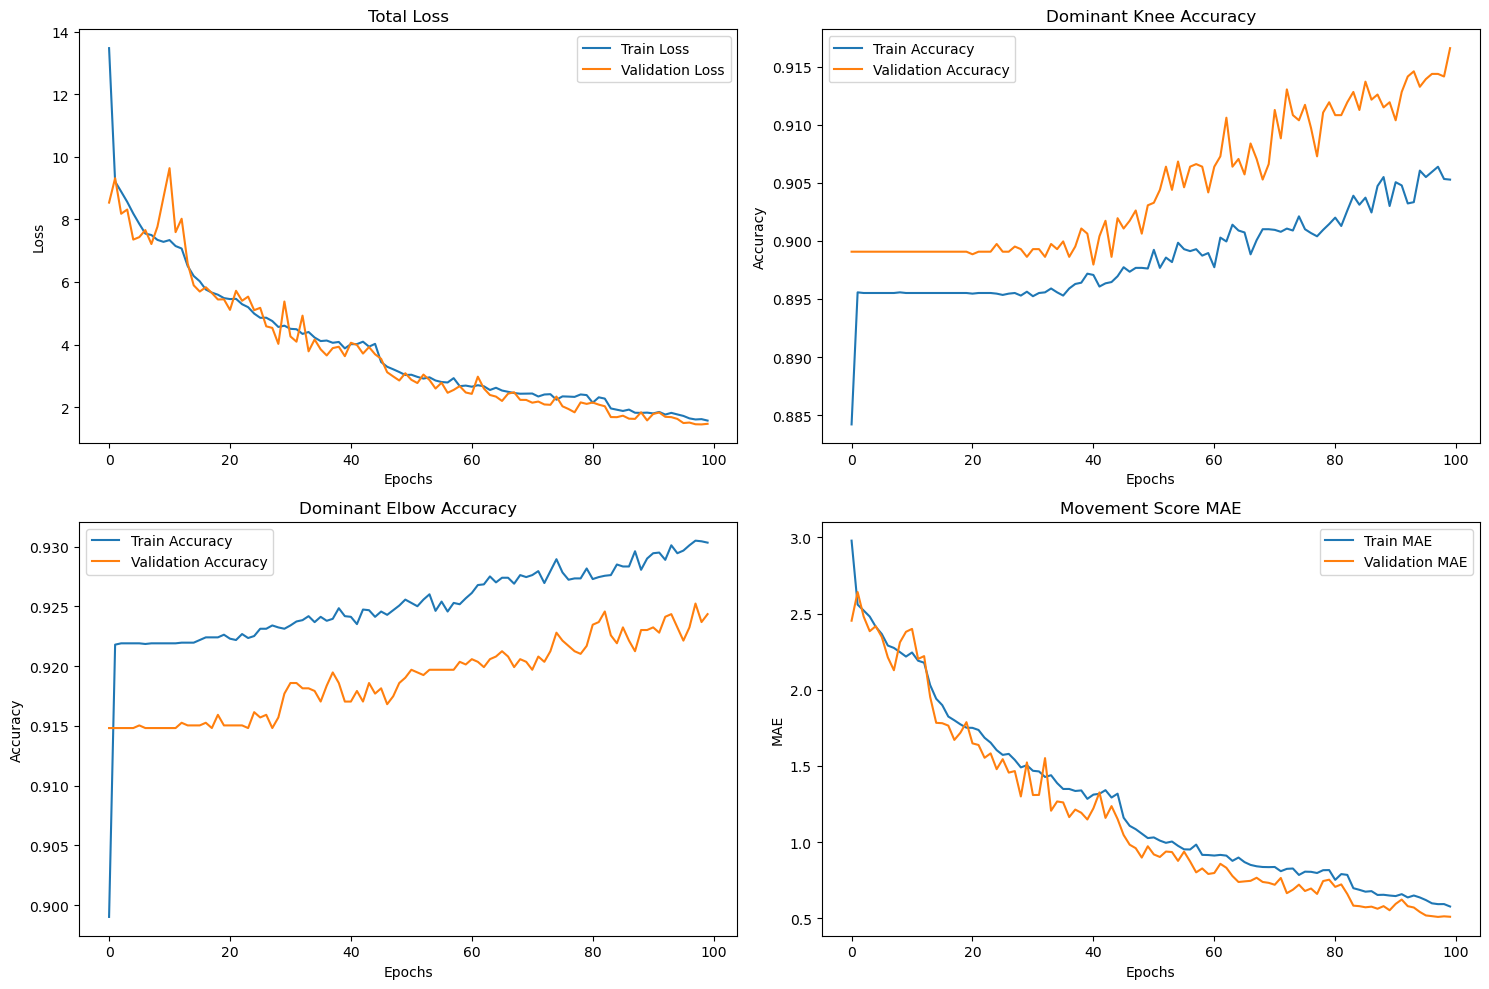

'infant_movement_gru_movenet_model.keras'

Movenet Training Ended
file is being proccessed: yolo_dataset.csv
 55117 Data rows have been loaded
number of examples: 28174
number of features: 40
number of classes for dominant knee: 2
number of classses for dominant elbow: 2
Epoch 1/100
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - dominant_elbow_accuracy: 0.5571 - dominant_elbow_loss: 0.7519 - dominant_knee_accuracy: 0.5222 - dominant_knee_loss: 0.7872 - loss: 8.5112 - movement_score_loss: 6.9721 - movement_score_mae: 1.8708
Epoch 1: val_loss improved from inf to 2.44007, saving model to best_infant_movement_model.keras
564/564 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step - dominant_elbow_accuracy: 0.5571 - dominant_elbow_loss: 0.7518 - dominant_knee_accuracy: 0.5222 - dominant_knee_loss: 0.7871 - loss: 8.5045 - movement_score_loss: 6.9656 - movement_score_mae: 1.8697 - val_dominant_elbow_accuracy: 0.6173 - val_dominant_elbow_loss: 0.6432 - val_dominant_knee_accuracy: 0.5355 - val_dominant_knee_loss:

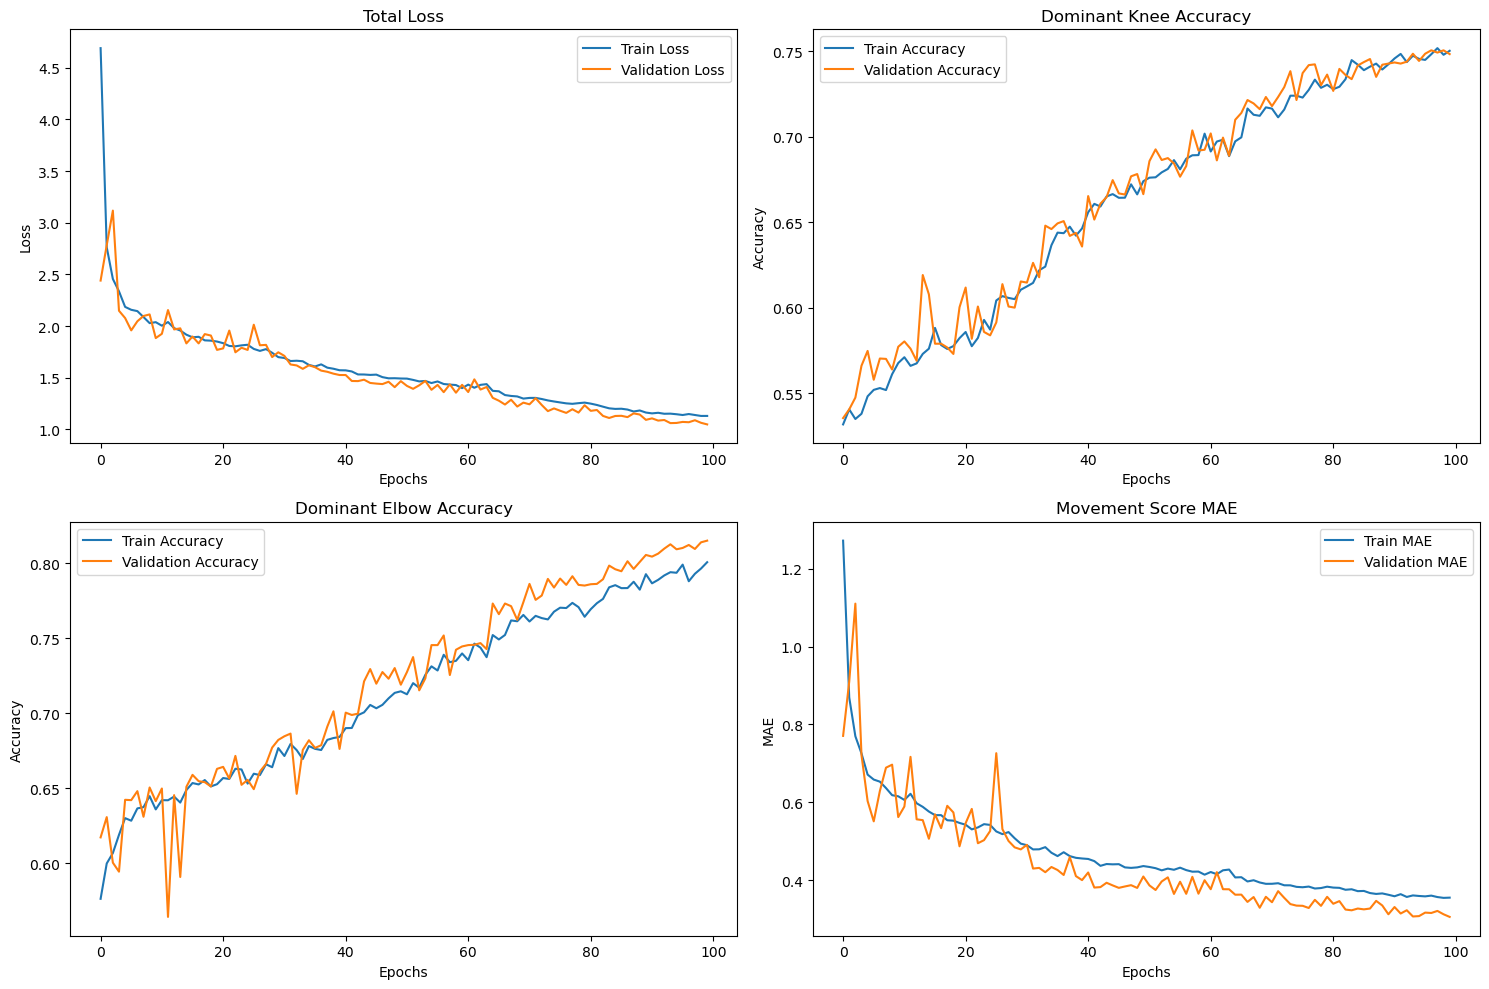

'infant_movement_gru_yolo_model.keras'

Yolo Training Ended
file is being proccessed: mediapipe_dataset.csv
 55078 Data rows have been loaded
number of examples: 28135
number of features: 40
number of classes for dominant knee: 2
number of classses for dominant elbow: 2
Epoch 1/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - dominant_elbow_accuracy: 0.5359 - dominant_elbow_loss: 0.7719 - dominant_knee_accuracy: 0.6699 - dominant_knee_loss: 0.6614 - loss: 7.2081 - movement_score_loss: 5.7748 - movement_score_mae: 1.7482
Epoch 1: val_loss improved from inf to 5.35003, saving model to best_infant_movement_model.keras
563/563 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step - dominant_elbow_accuracy: 0.5359 - dominant_elbow_loss: 0.7718 - dominant_knee_accuracy: 0.6700 - dominant_knee_loss: 0.6613 - loss: 7.2036 - movement_score_loss: 5.7705 - movement_score_mae: 1.7475 - val_dominant_elbow_accuracy: 0.6082 - val_dominant_elbow_loss: 0.6654 - val_dominant_knee_accuracy: 0.7155 - val_dominant_knee_loss: 

In [ ]:
def main():
    
    movenet_path = ['movenet_dataset.csv']
    
    print(f"file is being proccessed: {movenet_path[0]}")
    
    # טעינת הנתונים
    try:
        data, label_encoders = load_and_preprocess_data(movenet_path)
        print(f" {len(data)} Data rows have been loaded")
    except Exception as e:
        print(f"Error loading the data: {e}")
        return
    
    
    X, y_movement, y_knee, y_elbow, feature_columns = prepare_sequences(data)
    
    print(f"number of examples: {len(X)}")
    print(f"number of features: {X.shape[2]}")
    
    
    num_knee_classes = len(np.unique(y_knee))
    num_elbow_classes = len(np.unique(y_elbow))
    
    print(f"number of classes for dominant knee: {num_knee_classes}")
    print(f"number of classses for dominant elbow: {num_elbow_classes}")
    
    
    X_train_val, X_test, y_movement_train_val, y_movement_test, \
    y_knee_train_val, y_knee_test, y_elbow_train_val, y_elbow_test = train_test_split(
        X, y_movement, y_knee, y_elbow, test_size=0.2, random_state=RANDOM_STATE
    )
    
   
    X_train, X_val, y_movement_train, y_movement_val, \
    y_knee_train, y_knee_val, y_elbow_train, y_elbow_val = train_test_split(
        X_train_val, y_movement_train_val, y_knee_train_val, y_elbow_train_val, 
        test_size=0.2, random_state=RANDOM_STATE
    )
    
   
    
    
    input_shape = (X_train.shape[1], X_train.shape[2])
    
    
    y_train = [y_movement_train, y_knee_train, y_elbow_train]
    y_val = [y_movement_val, y_knee_val, y_elbow_val]
    
    # Model Training 
    model, history = train_model(
        X_train, y_train, X_val, y_val, 
        input_shape, num_knee_classes, num_elbow_classes
    )
    
    # Model Evaluation
    results = evaluate_model(
        model, X_test, y_movement_test, y_knee_test, y_elbow_test, label_encoders
    )
    
    
    plot_training_history(history)
    
    # Model Save
    model.save('infant_movement_gru_movenet_model.keras')
    print("'infant_movement_gru_movenet_model.keras'")
    
    
    with open('model_features.txt', 'w') as f:
        f.write('\n'.join(feature_columns))
    
    print("\nMovenet Training Ended")
    print("=" * 50)  


    yolo_path = ['yolo_dataset.csv']
    
    print(f"file is being proccessed: {yolo_path[0]}")
    
    # טעינת הנתונים
    try:
        data, label_encoders = load_and_preprocess_data(yolo_path)
        print(f" {len(data)} Data rows have been loaded")
    except Exception as e:
        print(f"Error loading the data: {e}")
        return
    
    
    X, y_movement, y_knee, y_elbow, feature_columns = prepare_sequences(data)
    
    print(f"number of examples: {len(X)}")
    print(f"number of features: {X.shape[2]}")
    
    
    num_knee_classes = len(np.unique(y_knee))
    num_elbow_classes = len(np.unique(y_elbow))
    
    print(f"number of classes for dominant knee: {num_knee_classes}")
    print(f"number of classses for dominant elbow: {num_elbow_classes}")
    
    
    X_train_val, X_test, y_movement_train_val, y_movement_test, \
    y_knee_train_val, y_knee_test, y_elbow_train_val, y_elbow_test = train_test_split(
        X, y_movement, y_knee, y_elbow, test_size=0.2, random_state=RANDOM_STATE
    )
    
   
    X_train, X_val, y_movement_train, y_movement_val, \
    y_knee_train, y_knee_val, y_elbow_train, y_elbow_val = train_test_split(
        X_train_val, y_movement_train_val, y_knee_train_val, y_elbow_train_val, 
        test_size=0.2, random_state=RANDOM_STATE
    )
    
   
    
    
    input_shape = (X_train.shape[1], X_train.shape[2])
    
    
    y_train = [y_movement_train, y_knee_train, y_elbow_train]
    y_val = [y_movement_val, y_knee_val, y_elbow_val]
    
    # Model Training 
    model, history = train_model(
        X_train, y_train, X_val, y_val, 
        input_shape, num_knee_classes, num_elbow_classes
    )
    
    # Model Evaluation
    results = evaluate_model(
        model, X_test, y_movement_test, y_knee_test, y_elbow_test, label_encoders
    )
    
    
    plot_training_history(history)
    
    # Model Save
    model.save('infant_movement_gru_yolo_model.keras')
    print("'infant_movement_gru_yolo_model.keras'")
    
    
    with open('model_features.txt', 'w') as f:
        f.write('\n'.join(feature_columns))
    
    print("\nYolo Training Ended")
    print("=" * 50)  



    mediapipe_path = ['mediapipe_dataset.csv']
    
    print(f"file is being proccessed: {mediapipe_path[0]}")
    
    
    try:
        data, label_encoders = load_and_preprocess_data(mediapipe_path)
        print(f" {len(data)} Data rows have been loaded")
    except Exception as e:
        print(f"Error loading the data: {e}")
        return
    
    
    X, y_movement, y_knee, y_elbow, feature_columns = prepare_sequences(data)
    
    print(f"number of examples: {len(X)}")
    print(f"number of features: {X.shape[2]}")
    
    
    num_knee_classes = len(np.unique(y_knee))
    num_elbow_classes = len(np.unique(y_elbow))
    
    print(f"number of classes for dominant knee: {num_knee_classes}")
    print(f"number of classses for dominant elbow: {num_elbow_classes}")
    
    
    X_train_val, X_test, y_movement_train_val, y_movement_test, \
    y_knee_train_val, y_knee_test, y_elbow_train_val, y_elbow_test = train_test_split(
        X, y_movement, y_knee, y_elbow, test_size=0.2, random_state=RANDOM_STATE
    )
    
   
    X_train, X_val, y_movement_train, y_movement_val, \
    y_knee_train, y_knee_val, y_elbow_train, y_elbow_val = train_test_split(
        X_train_val, y_movement_train_val, y_knee_train_val, y_elbow_train_val, 
        test_size=0.2, random_state=RANDOM_STATE
    )
    
   
    
    
    input_shape = (X_train.shape[1], X_train.shape[2])
    
    
    y_train = [y_movement_train, y_knee_train, y_elbow_train]
    y_val = [y_movement_val, y_knee_val, y_elbow_val]
    
    # Model Training 
    model, history = train_model(
        X_train, y_train, X_val, y_val, 
        input_shape, num_knee_classes, num_elbow_classes
    )
    
    # Model Evaluation
    results = evaluate_model(
        model, X_test, y_movement_test, y_knee_test, y_elbow_test, label_encoders
    )
    
    
    plot_training_history(history)
    
    # Model Save
    model.save('infant_movement_gru_mediapipe_model.keras')
    print("'infant_movement_gru_mediapipe_model.keras'")
    
    
    with open('model_features.txt', 'w') as f:
        f.write('\n'.join(feature_columns))
    
    print("\nMediapipe Training Ended")
    print("=" * 50)  


if __name__ == "__main__":
    main()